In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

In [4]:
image_size = (128,128)
batch_size = 10

training_data_dir = r'C:\DeepLearning\RealImages\Train'
validation_data_dir = r'C:\DeepLearning\RealImages\Validation'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 7795 images belonging to 100 classes.
Found 2803 images belonging to 100 classes.


In [5]:
x_batch, y_batch = next(train_generator)

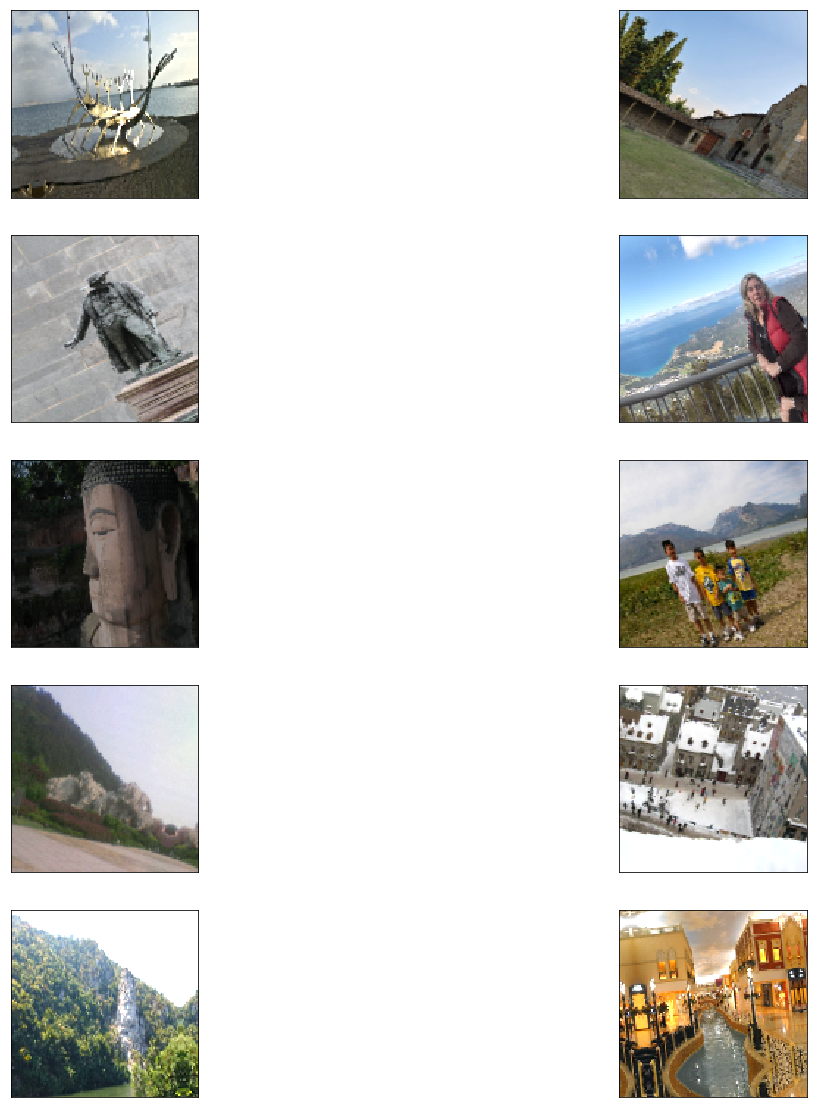

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

In [7]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [8]:
base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))

In [9]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [10]:
for layer in base_model.layers[:]:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [11]:
for layer in base_model.layers[:]:
    layer.trainable = False

In [12]:
classCount = 100

x=base_model.output
x = Dropout(0.3, input_shape=(4,4,512))(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=Conv2D(input_shape=(4,4,512), filters=512, kernel_size=[3,3],activation='tanh',padding='same')(x)
x=MaxPooling2D(input_shape=(4,4,512),pool_size=(2,2),strides=(2,2))(x)
x = Dropout(0.3, input_shape=(4,4,512))(x)
x=Flatten()(x)
preds=Dense(classCount,activation='softmax')(x) #final layer with softmax activation

model_final=Model(inputs=base_model.input,outputs=preds)

In [13]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [14]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

In [15]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

779


In [16]:
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        
history = LossAccHistory()

In [ ]:
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=10
                   ,callbacks = [history])

import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

import time

networkfileName = "D:\DeepLearningH5\\vgg16_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = LossAccHistory()
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=5
                   ,callbacks = [history, checkpoint, early])

import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

Epoch 1/10
779/779 [==============================] - 954s 1s/step - loss: 2.9894 - acc: 0.3080 - val_loss: 1.9113 - val_acc: 0.5309
Epoch 2/10
779/779 [==============================] - 958s 1s/step - loss: 1.7133 - acc: 0.5674 - val_loss: 1.4725 - val_acc: 0.6215
Epoch 3/10
779/779 [==============================] - 957s 1s/step - loss: 1.4084 - acc: 0.6345 - val_loss: 1.2564 - val_acc: 0.6621
Epoch 4/10
779/779 [==============================] - 957s 1s/step - loss: 1.2281 - acc: 0.6769 - val_loss: 1.1611 - val_acc: 0.6957
Epoch 5/10
779/779 [==============================] - 957s 1s/step - loss: 1.1249 - acc: 0.6879 - val_loss: 1.0782 - val_acc: 0.7182
Epoch 6/10
779/779 [==============================] - 958s 1s/step - loss: 1.0584 - acc: 0.7099 - val_loss: 1.0625 - val_acc: 0.7207
Epoch 7/10
779/779 [==============================] - 958s 1s/step - loss: 0.9956 - acc: 0.7234 - val_loss: 0.9966 - val_acc: 0.7371
Epoch 8/10
779/779 [==============================] - 958s 1s/step - 

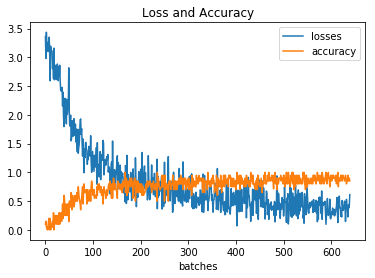

Epoch 1/5
79/80 [============================>.] - ETA: 1s - loss: 0.3662 - acc: 0.8937
Epoch 00001: val_acc improved from -inf to 0.89587, saving model to C:\ML666\vgg16_v2.h5
80/80 [==============================] - 192s 2s/step - loss: 0.3666 - acc: 0.8937 - val_loss: 0.3541 - val_acc: 0.8959
Epoch 2/5
79/80 [============================>.] - ETA: 1s - loss: 0.3487 - acc: 0.8944
Epoch 00002: val_acc improved from 0.89587 to 0.90305, saving model to C:\ML666\vgg16_v2.h5
80/80 [==============================] - 192s 2s/step - loss: 0.3499 - acc: 0.8945 - val_loss: 0.3315 - val_acc: 0.9031
Epoch 3/5
79/80 [============================>.] - ETA: 1s - loss: 0.3320 - acc: 0.8968
Epoch 00003: val_acc did not improve from 0.90305
80/80 [==============================] - 194s 2s/step - loss: 0.3296 - acc: 0.8981 - val_loss: 0.3580 - val_acc: 0.8941
Epoch 4/5
79/80 [============================>.] - ETA: 1s - loss: 0.2915 - acc: 0.9052
Epoch 00004: val_acc did not improve from 0.90305
80/80 [

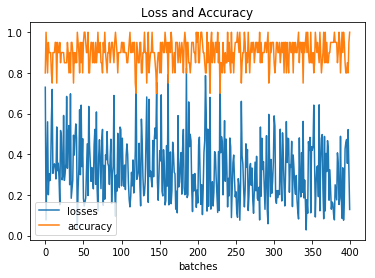

In [33]:
import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# The directory of KNN train data
data_dir = r'E:\Index'

# The neural network model into base_model
base_model = load_model('D:\DeepLearningH5\\vgg16_1549482952.h5')

# Cut the customized layers from the read resnet algorithm
x=base_model.get_layer('dropout_1').output

# Eport network to one dimension
vector=Flatten()(x)

# Make the model with the whole network as input and the vector as output
model = Model(inputs=base_model.input, outputs=vector)

datagen = ImageDataGenerator()     # Creating the Data generator

# Generator from the images
generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=1,
        class_mode='categorical',  # only data, no labels
        shuffle=False)  # keep data in same order as label

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Found 105573 images belonging to 11 classes.


In [ ]:
import numpy as np
from sklearn.externals import joblib

imgsList = []
proccImgs = []
labels = []

# For each image in the generator
for i in range(generator.n):
    (img, lbl) = generator.next();
    
    # Adding the image to the list of images
    imgsList.append(img)
    
    # Adding the proccessed images to the list of processed imaged
    proccImgs.append(np.reshape(model.predict_on_batch(img), -1))
    
    # Adding the image labels to list of labels
    labels.append(np.argmax(lbl))
    
    print("Adding " + str(i) + " image")
    
print(labels)

# Export the images vector (of the index images that will be tested in KNN algorithm) to the test day
imgs_file = r'E:\KNN Data\\images3.npy'

np.save(imgs_file, imgsList)

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)

# Fit with KNN algorithm with the proccessed images and labels
neigh.fit(proccImgs, labels)

knn_data = r'E:\KNN Data\\knn.sav'

# Export the KNN data train to the test day
joblib.dump(neigh, knn_data)

Adding 0 image
Adding 1 image
Adding 2 image
Adding 3 image
Adding 4 image
Adding 5 image
Adding 6 image
Adding 7 image
Adding 8 image
Adding 9 image
Adding 10 image
Adding 11 image
Adding 12 image
Adding 13 image
Adding 14 image
Adding 15 image
Adding 16 image
Adding 17 image
Adding 18 image
Adding 19 image
Adding 20 image
Adding 21 image
Adding 22 image
Adding 23 image
Adding 24 image
Adding 25 image
Adding 26 image
Adding 27 image
Adding 28 image
Adding 29 image
Adding 30 image
Adding 31 image
Adding 32 image
Adding 33 image
Adding 34 image
Adding 35 image
Adding 36 image
Adding 37 image
Adding 38 image
Adding 39 image
Adding 40 image
Adding 41 image
Adding 42 image
Adding 43 image
Adding 44 image
Adding 45 image
Adding 46 image
Adding 47 image
Adding 48 image
Adding 49 image
Adding 50 image
Adding 51 image
Adding 52 image
Adding 53 image
Adding 54 image
Adding 55 image
Adding 56 image
Adding 57 image
Adding 58 image
Adding 59 image
Adding 60 image
Adding 61 image
Adding 62 image
Ad

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

['D:\\DeepLearning\\KNN Data\\\\knn.sav']